Nur nen test zu autoencodern

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import json
from tensorflow.keras.callbacks import EarlyStopping
#tf.config.set_visible_devices([], 'GPU')

In [3]:
def add_salt_and_pepper_noise(image, noise_ratio=0.2):
    noise_iamge = image.copy()
    h, w, c = noise_iamge.shape
    noisy_pixels = int(h * w * noise_ratio)
 
    for _ in range(noisy_pixels):
        row, col = np.random.randint(0, h), np.random.randint(0, w)
        if np.random.rand() < 0.5:
            noise_iamge[row, col] = [0, 0, 0] 
        else:
            noise_iamge[row, col] = [255, 255, 255]
 
    return (noise_iamge).astype(np.float16)

def add_gaussian_noise(image, mean=0, std=0.3):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return (noisy_image).astype(np.float16)


In [4]:
# load image data, remove class and reshape 
data = pd.read_pickle('../data/images_df_numerical.pkl')
X,y = data['data'], data['Species']
X, y = np.stack(X).astype(np.float16), y.to_numpy().astype(np.uint8)
print(X.shape, y.shape)
image_size = X.size
samples = X.size
with open("../data/meta.json","r") as file:  # Shape der Bilder nach dem resizen aus dem data_prep notebook
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c'])
X = X.reshape((-1,) + image_shape)



#data = [cv2.fastNlMeansDenoising(image, None, h=15, templateWindowSize=5, searchWindowSize=21) for image in data]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train, random_state=42)

X_train_noise = X_train #[add_salt_and_pepper_noise(image) for image in X_train]
X_test_noise = X_test #[add_salt_and_pepper_noise(image) for image in X_test]
X_val_noise = X_val #[add_salt_and_pepper_noise(image) for image in X_val]

#print(X_train)
y_train = np.asarray(X_train)
X_train = np.asarray(X_train_noise)
y_test = np.asarray(X_test)
X_test = np.asarray(X_test_noise)
y_val = np.asarray(X_val)
X_val = np.asarray(X_val_noise)

print("Total Number of Images:\t\t",len(data))
print("Number of Images for Training:\t",len(X_train))
print("Number of Images for Test:\t",len(X_test))

(3722, 31488) (3722,)
(2977, 82, 128, 3) (2977,)
(745, 82, 128, 3) (745,)
Total Number of Images:		 3722
Number of Images for Training:	 2381
Number of Images for Test:	 596


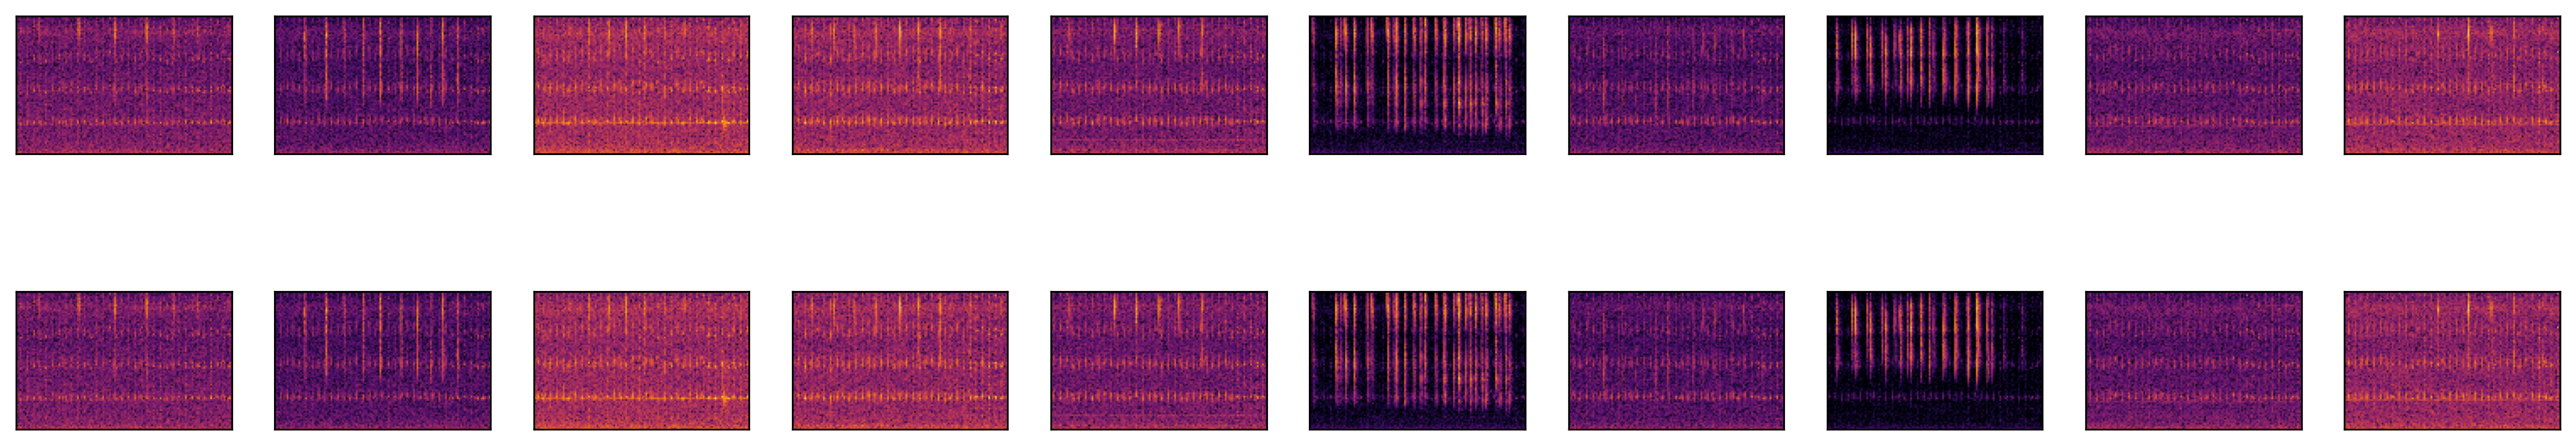

In [5]:
# display some of the images vs reconstruction
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor((y_train[i]*255.).astype(np.uint8), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Noiseed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor((X_train[i]*255.).astype(np.uint8), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("test_autoencoder_cnn_reconstruction.png",dpi=600)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(2381, 82, 128, 3)
(2381, 82, 128, 3)
(596, 82, 128, 3)
(596, 82, 128, 3)
(745, 82, 128, 3)
(745, 82, 128, 3)


In [7]:
# cnn as en/decoder
weight_decay_alpha = 0.01
shapes = image_shape

input = layers.Input(shape=image_shape)

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = keras.Model(input, x)

# compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])
autoencoder.summary()

# train on data
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.01, start_from_epoch=15, restore_best_weights=True)
autoencoder.fit(X_train,y_train,
                epochs=200,
                batch_size=30,
                validation_data=[X_val,y_val],
                callbacks=[early_stopping]
               )

# save model
autoencoder.save('../ae_files/test_autoencoder_cnn.keras')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 82, 128, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 82, 128, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 32, 32)        9248  

2024-01-17 15:51:44.898985: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-17 15:51:44.899010: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-17 15:51:44.899014: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-17 15:51:44.899043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 15:51:44.899058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2024-01-17 15:51:45.651631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 4s 47ms/step - loss: 0.5613 - accuracy: 0.6852 - val_loss: 0.5361 - val_accuracy: 0.8131
Epoch 2/200
80/80 [==============================] - 3s 41ms/step - loss: 0.5302 - accuracy: 0.8245 - val_loss: 0.5319 - val_accuracy: 0.8167
Epoch 3/200
80/80 [==============================] - 3s 41ms/step - loss: 0.5267 - accuracy: 0.8259 - val_loss: 0.5290 - val_accuracy: 0.8292
Epoch 4/200
80/80 [==============================] - 3s 43ms/step - loss: 0.5247 - accuracy: 0.8330 - val_loss: 0.5276 - val_accuracy: 0.8283
Epoch 5/200
80/80 [==============================] - 3s 42ms/step - loss: 0.5235 - accuracy: 0.8395 - val_loss: 0.5265 - val_accuracy: 0.8375
Epoch 6/200
80/80 [==============================] - 3s 43ms/step - loss: 0.5227 - accuracy: 0.8444 - val_loss: 0.5258 - val_accuracy: 0.8410
Epoch 7/200
80/80 [==============================] - 3s 42ms/step - loss: 0.5220 - accuracy: 0.8474 - val_loss: 0.5249 - val_accuracy: 0.8450
Epoch 8/200
80/80 

In [8]:
# predict some images
autoencoder = keras.saving.load_model('../ae_files/test_autoencoder_cnn.keras')
denoised_input = autoencoder.predict(X_test)
denoised_target = autoencoder.predict(y_test)

19/19 [==============================] - 0s 11ms/step


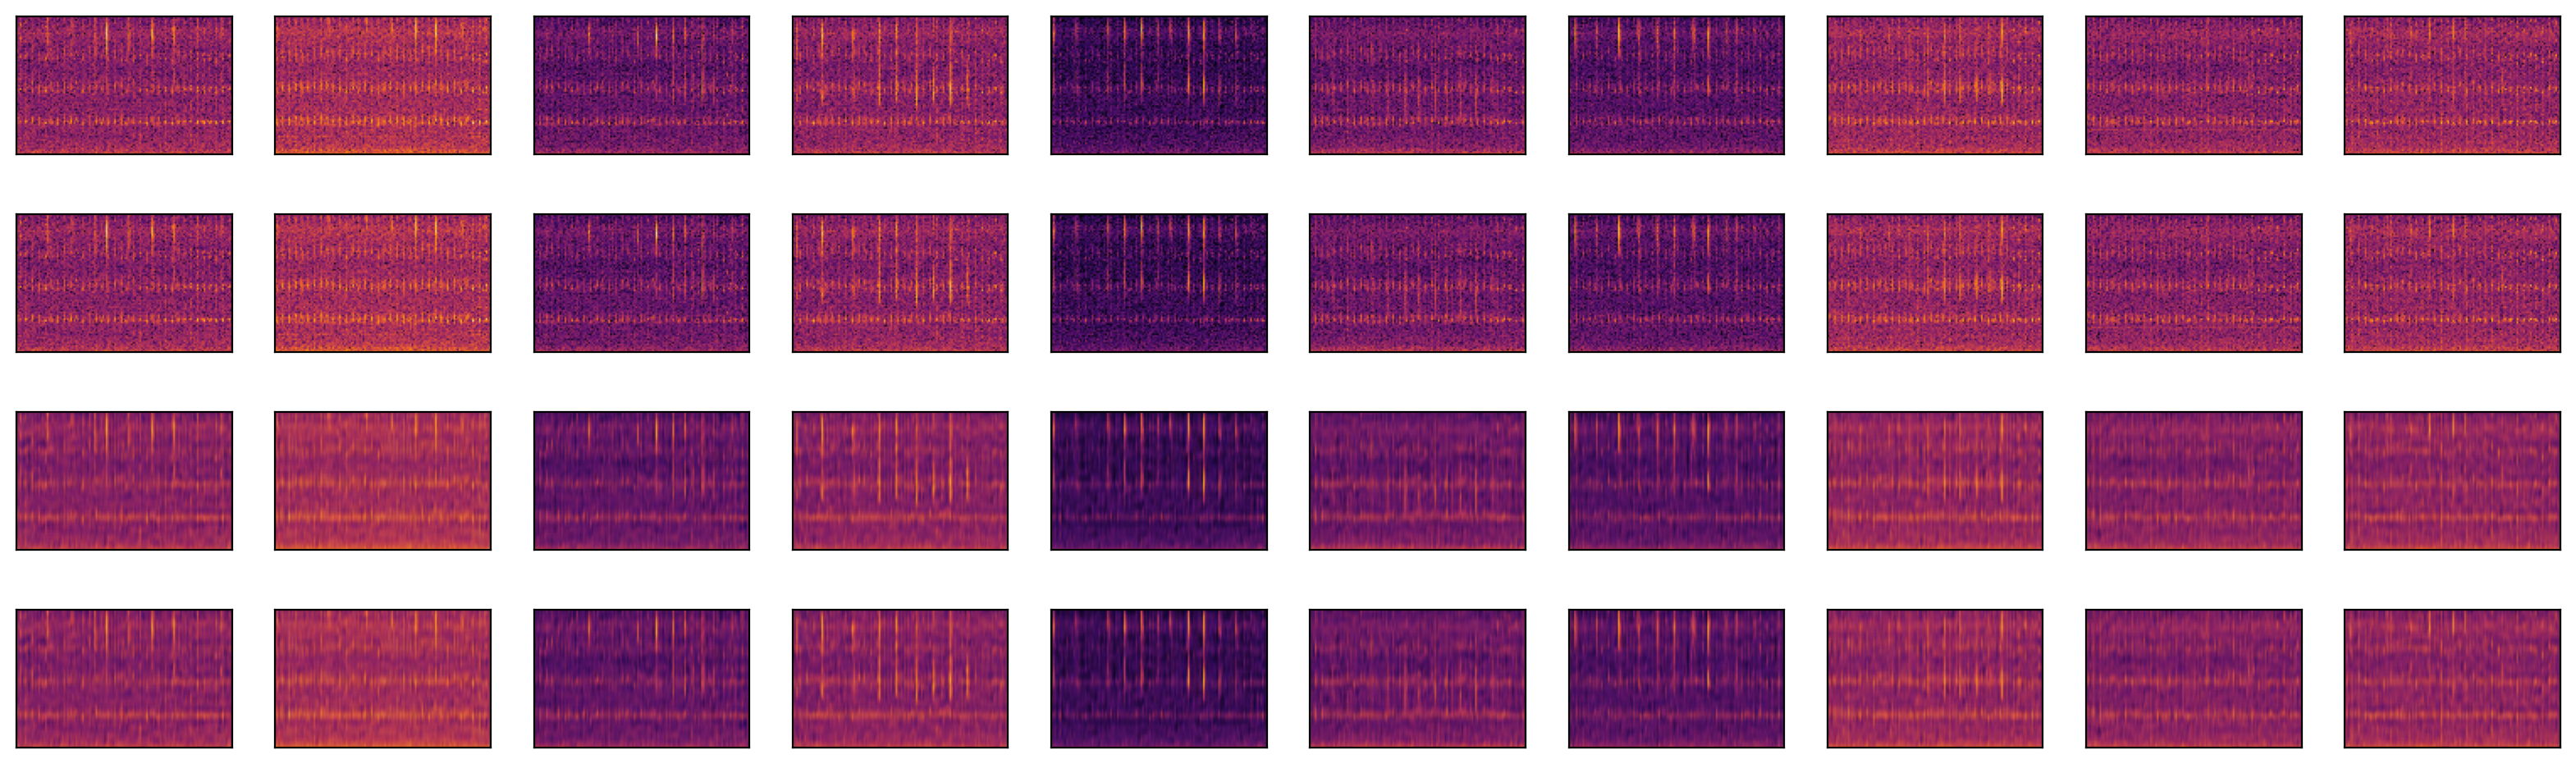

In [9]:
# display some of the images vs reconstruction
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original/target
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(cv2.cvtColor((y_test[i].reshape(image_shape)*255.).astype(np.uint8), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display noise/input
    ax = plt.subplot(4, n, i + 1+n)
    plt.imshow(cv2.cvtColor((X_test[i].reshape(image_shape)*255.).astype(np.uint8), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction/denoised on input
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(cv2.cvtColor((denoised_input[i].reshape(image_shape)*255.).astype(np.uint8), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction/denoised on target
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(cv2.cvtColor((denoised_target[i].reshape(image_shape)*255.).astype(np.uint8), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("test_autoencoder_cnn_reconstruction.png",dpi=600)